In [347]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import cvxpy as cp
import sklearn.metrics

In [311]:
dataset = 'spark.cytoband'
k = 5
lambda_X = 1.0
lambda_Y_G = 1.0
lambda_Y_P = 0.0


In [312]:
intervals = np.load('../permutation_tests/phen.%s.intervals.npy' % dataset)
chroms = np.load('../permutation_tests/phen.%s.chroms.npy' % dataset)
print(intervals.shape, chroms.shape)

chrom_lengths38 = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
	'X': 156040895,
#	'Y': 57227415
}

chrom_to_offset = dict()
offset = 0
for chrom in range(1, 23):
    chrom_to_offset[str(chrom)] = offset
    offset += chrom_lengths38[str(chrom)]
    
x = intervals[0, :] + np.array([chrom_to_offset[x] for x in chroms])

(2, 811) (811,)


In [313]:
with open('../../PhenotypeGLRM/preprocessing/schemas/SCQ.json', 'r') as f:
    scq = json.load(f)

In [315]:
mat_ibd = np.load('../permutation_tests/phen.%s.mat_ibd.npy' % dataset)
pat_ibd = np.load('../permutation_tests/phen.%s.pat_ibd.npy' % dataset)
G_orig = mat_ibd + pat_ibd
G_orig[G_orig==0] = 1
G_orig[G_orig==-2] = 0
G_orig[(mat_ibd==0) | (pat_ibd==0)] = -1

sample_to_phen = dict()
with open('../../PhasingFamilies/phenotypes/spark_v5/spark_v5-scq-prep.csv', 'r') as f:
    reader = csv.reader(f)
    for pieces in reader:
        phen = pieces[13:53]
        sample_to_phen[pieces[2]] = np.array([1 if x=='1.0' else -1 if x=='0.0' else 0 for x in phen])
            
print('phen', len(sample_to_phen))

P_orig = np.zeros((len(sibpairs), 40))
for i, sibpair in enumerate(sibpairs):
    if sibpair['sibling1'] in sample_to_phen and sibpair['sibling2'] in sample_to_phen:
        phen1 = sample_to_phen[sibpair['sibling1']]
        phen2 = sample_to_phen[sibpair['sibling2']]
        is_not_missing = (phen1 != 0) & (phen2 != 0)
        P_orig[i, is_not_missing] = np.sign(np.multiply(phen1[is_not_missing], phen2[is_not_missing]))


no_pheno = np.all(P_orig==0, axis=1)


G = G_orig[~no_pheno, :]#[:500, :]
P = P_orig[~no_pheno, :]#[:500, :]
print('G', G.shape, 'P', P.shape)

num_sibpairs = G.shape[0] # num sibpairs
num_features_G = G.shape[1] # num features
num_features_P = P.shape[1] # num features
print(num_sibpairs, num_features_G, num_features_P)

is_masked_G = (G!=-1) & (np.random.random((num_sibpairs, num_features_G))<0.1)
is_masked_P = (P!=0) & (np.random.random((num_sibpairs, num_features_P))<0.1)
is_missing_G = (G==-1) | is_masked_G
is_missing_P = (P==0) | is_masked_P
print('G', np.sum(is_masked_G)/(num_sibpairs*num_features_G), 
      np.sum(G==-1)/(num_sibpairs*num_features_G))
print('P', np.sum(is_masked_P)/(num_sibpairs*num_features_P), 
      np.sum(P==0)/(num_sibpairs*num_features_P))

P[P==-1] = 0

phen 68935
G (5376, 811) P (5376, 40)
5376 811 40
G 0.09980284114262228 0.0004623921085080148
P 0.09602864583333333 0.03999255952380952


In [354]:
X = np.load('../low_rank_models/X.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))
Y_G = np.load('../low_rank_models/Y_G.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))
Y_P = np.load('../low_rank_models/Y_P.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))
Y_P = np.load('../low_rank_models/Y_P.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))
is_masked_G = np.load('../low_rank_models/is_masked_G.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))
is_masked_P = np.load('../low_rank_models/is_masked_P.%s.%d.%0.2f.%0.2f.%0.2f.npy' % (dataset, k, lambda_X, lambda_Y_G, lambda_Y_P))




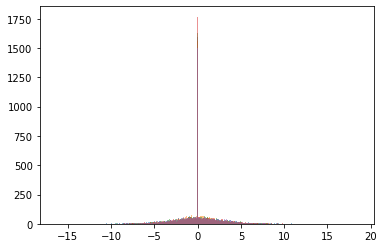

In [355]:
bins = np.arange(np.min(X), np.max(X)+0.1, 0.1)
for i in range(k):
    plt.hist(X[:, i+1], bins=bins, alpha=0.5)
plt.show()

In [356]:
print(np.sum(X>0.1, axis=0))

[5376 1868 1856 1839 1791 1904]


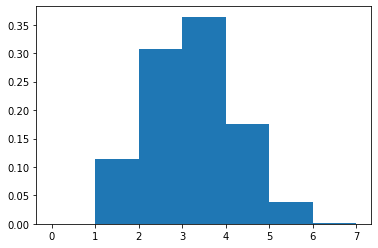

In [357]:
plt.hist(np.sum(X>0.1, axis=1), bins=np.arange(8), density=True)
plt.show()

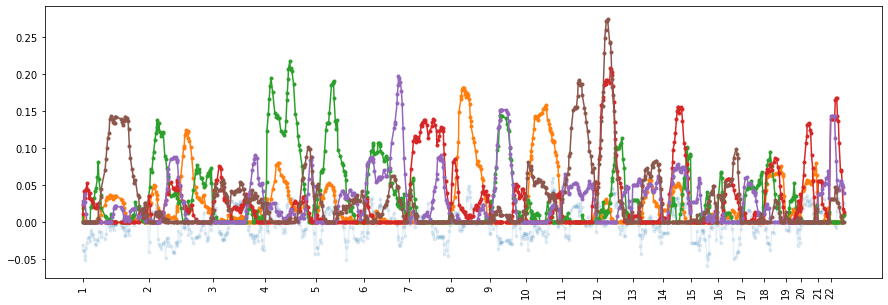

In [358]:
plt.figure(figsize=(15, 5))
plt.plot(x, Y_G[0, :], marker='.', alpha=0.1)
for i in range(1, k+1):
    plt.plot(x, Y_G[i, :], marker='.', alpha=1.0)

plt.xticks([chrom_to_offset[str(x)] for x in range(1, 23)], [str(x) for x in range(1, 23)], rotation=90)
plt.show()

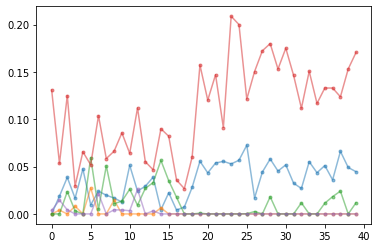

In [359]:
#plt.plot(np.arange(40), Y_P[0, :], marker='.', alpha=0.1)
for i in range(1, k+1):
    plt.plot(np.arange(40), Y_P[i, :], marker='.', alpha=0.5)


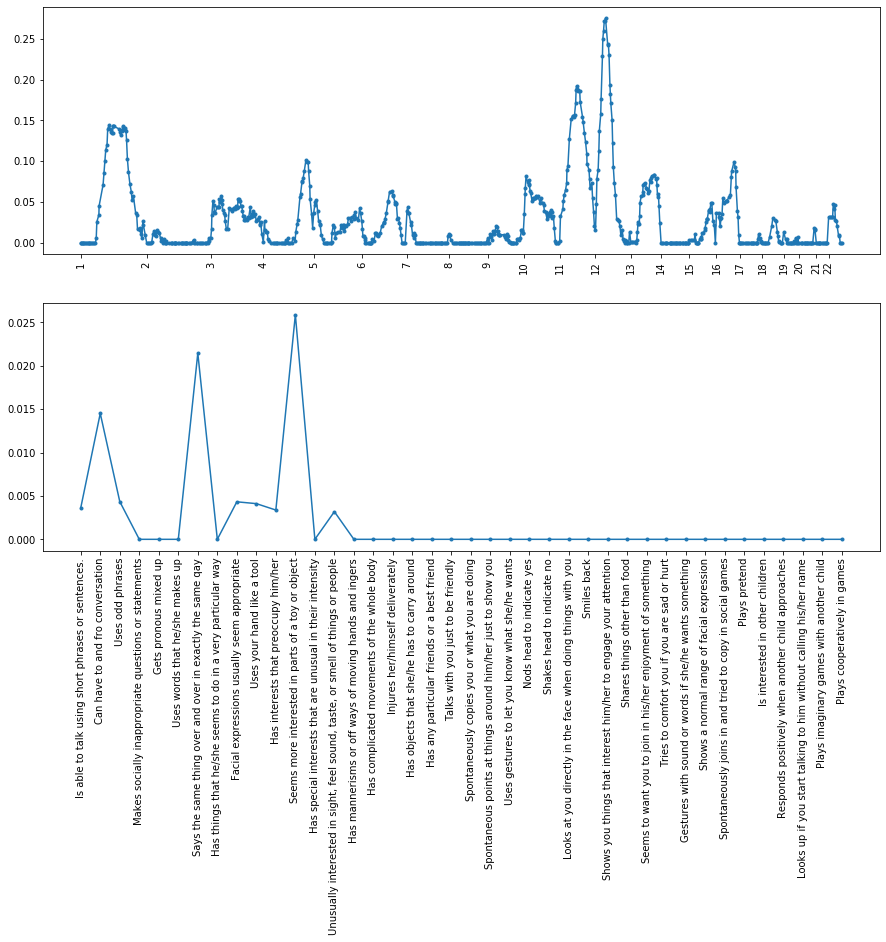

In [369]:
i = 4
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(x, Y_G[i+1, :], marker='.', alpha=1.0)
plt.xticks([chrom_to_offset[str(x)] for x in range(1, 23)], [str(x) for x in range(1, 23)], rotation=90)

plt.subplot(2, 1, 2)
plt.plot(np.arange(40), Y_P[i+1, :], marker='.', alpha=1.0)
plt.xticks(np.arange(40), [scq['properties']['Q%s' % str(j+1).zfill(2)]['description'] for j in np.arange(40)], rotation=90)
plt.show()

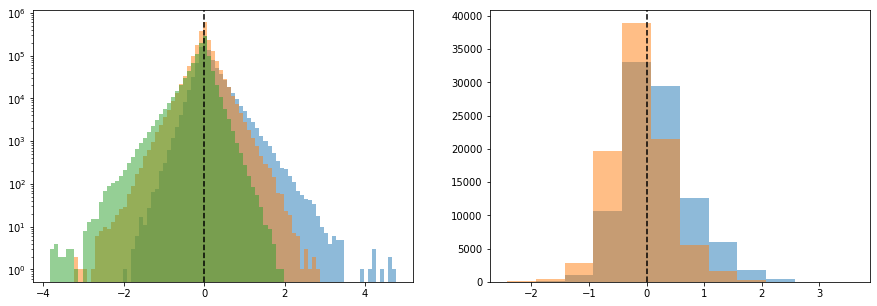

In [361]:
plt.figure(figsize=(15, 5))
G_est = X.dot(Y_G)
P_est = X.dot(Y_P)

plt.subplot(1, 2, 1)
bins = np.arange(np.min(G_est), np.max(G_est)+0.1, 0.1)
plt.hist(G_est[(G==2) & ~is_missing_G], bins=bins, alpha=0.5, log=True)
plt.hist(G_est[(G==1) & ~is_missing_G], bins=bins, alpha=0.5, log=True)
plt.hist(G_est[(G==0) & ~is_missing_G], bins=bins, alpha=0.5, log=True)
plt.axvline(0, linestyle='--', color='black')

plt.subplot(1, 2, 2)
bins = np.arange(np.min(P_est), np.max(P_est)+0.5, 0.5)
plt.hist(P_est[(P==1) & ~is_missing_P], bins=bins, alpha=0.5)
plt.hist(P_est[(P==0) & ~is_missing_P], bins=bins, alpha=0.5)
plt.axvline(0, linestyle='--', color='black')
plt.show()

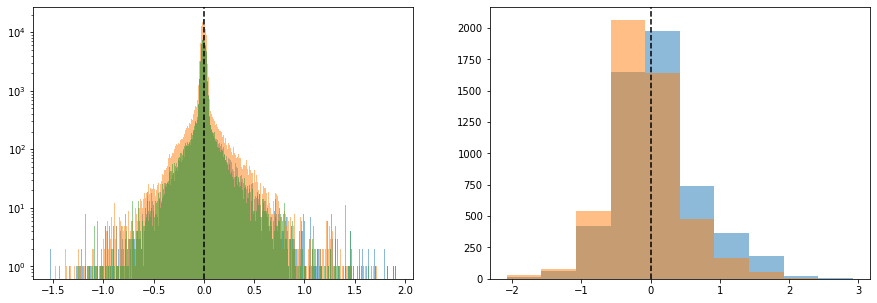

In [362]:
plt.figure(figsize=(15, 5))
G_est = X.dot(Y_G)
P_est = X.dot(Y_P)

plt.subplot(1, 2, 1)
bins = np.arange(np.min(G_est[is_masked_G]), np.max(G_est[is_masked_G])+0.01, 0.01)
plt.hist(G_est[(G==2) & is_masked_G], bins=bins, alpha=0.5, log=True)
plt.hist(G_est[(G==1) & is_masked_G], bins=bins, alpha=0.5, log=True)
plt.hist(G_est[(G==0) & is_masked_G], bins=bins, alpha=0.5, log=True)
plt.axvline(0, linestyle='--', color='black')

ax = plt.subplot(1, 2, 2)
bins = np.arange(np.min(P_est[is_masked_P]), np.max(P_est[is_masked_P])+0.5, 0.5)
plt.hist(P_est[(P==1) & is_masked_P], bins=bins, alpha=0.5)
plt.hist(P_est[(P==0) & is_masked_P], bins=bins, alpha=0.5)
plt.axvline(0, linestyle='--', color='black')
plt.show()

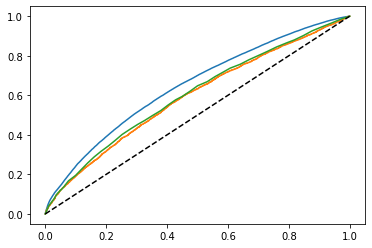

In [364]:
P_est = X.dot(Y_P)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(P[~is_masked_P], P_est[~is_masked_P])
plt.plot(fpr, tpr)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(P[is_masked_P], P_est[is_masked_P])
plt.plot(fpr, tpr)

P_est = X[:, 0, np.newaxis].dot(Y_P[np.newaxis, 0, :])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(P[is_masked_P], P_est[is_masked_P])
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

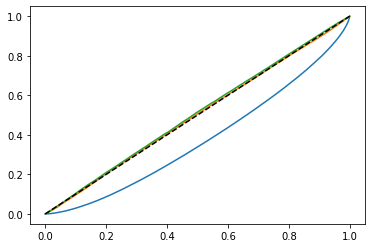

In [375]:
G_est = X.dot(Y_G)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(G[~is_masked_G], G_est[~is_masked_G], pos_label=0)
plt.plot(fpr, tpr)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(G[is_masked_G], G_est[is_masked_G], pos_label=0)
plt.plot(fpr, tpr)

G_est = X[:, 0, np.newaxis].dot(Y_G[np.newaxis, 0, :])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(G[is_masked_G], G_est[is_masked_G], pos_label=0)
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()